In [1]:
from tensorflow.python.keras import layers
import numpy as np
from tensorflow.python.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from PIL import Image
import os.path
import glob
import os
import cv2
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.ensemble import IsolationForest
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

2022-05-06 11:29:13.382826: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-05-06 11:29:16.301732: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-06 11:29:16.312755: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-05-06 11:29:16.418343: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:d6:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2022-05-06 11:29:16.418380: I tensorflow/stream_executor/platform/default

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d6:00.0, compute capability: 8.6



2022-05-06 11:29:16.959969: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-05-06 11:29:16.959996: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2022-05-06 11:29:16.960001: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2022-05-06 11:29:16.962120: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 22308 MB memory) -> physical GPU (device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d6:00.0, compute capability: 8.6)


In [ ]:
def convertjpg(jpgfile,outdir,width=64,height=64):
    img=Image.open(jpgfile)   
    new_img=img.resize((width,height),Image.BILINEAR)   
    new_img.save(os.path.join(outdir,os.path.basename(jpgfile)))
for jpgfile in glob.glob('/root/autodl-tmp/thispersondoesnotexist.10k/*.jpg'):
    convertjpg(jpgfile,'/root/autodl-tmp/thispersondoesnotexist.10k')
for jpgfile in glob.glob('/root/autodl-tmp/0/*.jpg'):
    convertjpg(jpgfile,'/root/autodl-tmp/0')

In [2]:
def getFileName(filepath):
    path_list = []
    pathList = os.listdir(filepath)
    for allFile in pathList:
        everyFile = os.path.join(filepath, allFile)
        path_list.append(everyFile)
    return path_list
training_path = getFileName('/root/autodl-tmp/thispersondoesnotexist.10k')
testing_path = getFileName('/root/autodl-tmp/0')

In [3]:
training_path = training_path[:10000]

In [4]:
testing_img_path = training_path[:800] + testing_path[:200]
training_img_path = training_path[800:]

In [5]:
test_y = 800*[0] + 200*[1]
test_y = np.array(test_y)

In [6]:
train = np.array([cv2.imdecode(np.fromfile(path,dtype=np.uint8),-1)/ 255. for path in training_img_path])
train = train.reshape(9200,64,64,3)
print(train.shape)
test = np.array([cv2.imdecode(np.fromfile(path,dtype=np.uint8),-1)/ 255. for path in testing_img_path])
test = test.reshape(1000,64,64,3)
print(test.shape)

(9200, 64, 64, 3)
(1000, 64, 64, 3)


In [7]:
clf = IsolationForest()

In [8]:
train_neg = [t.reshape(t.shape[0]* t.shape[1] * t.shape[2]) for t in train]

In [9]:
clf.fit(train_neg)

IsolationForest()

/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

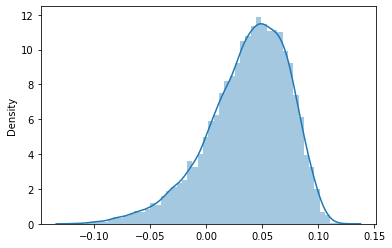

In [10]:
scores = clf.decision_function(train_neg)
sns.distplot(scores)

In [11]:
test_tmp = [t.reshape(t.shape[0]* t.shape[1] * t.shape[2]) for t in test]

/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

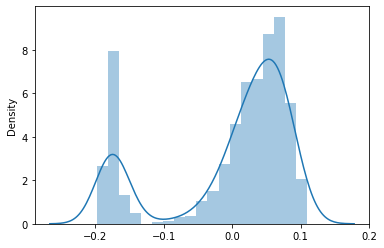

In [12]:
scores2 = clf.decision_function(test_tmp)
sns.distplot(scores2)

In [26]:
result = clf.predict(test_tmp)
result = result.reshape(1000,1)

In [18]:
from sklearn.metrics import roc_auc_score
test_y = test_y.reshape(1000,1)
TP = ((test_y==1) & (result==-1)).sum()
FN = ((test_y==1) & (result==1)).sum()
FP = ((test_y==0) & (result==-1)).sum()
TN = ((test_y==0) & (result==1)).sum()
acc = (TP+TN)/1000
recall = TP/(TP+FN)
precision = TP/(TP+FP)
f1 = 2*precision*recall/(precision+recall)
print('accuracy: %.3f, recall: %.3f, precision: %.3f, related f1 score: %.3f'%(acc,recall,precision,f1))
print('In %d data of test set, TP: %d, FN: %d, FP: %d, TN: %d'%(len(test_y),TP,FN,FP,TN))

accuracy: 0.889, recall: 1.000, precision: 0.643, related f1 score: 0.783, AUC: 0.069
In 1000 data of test set, TP: 200, FN: 0, FP: 111, TN: 689


In [28]:
result[np.where(result==1),:] = 0

In [29]:
result[np.where(result==-1),:] = 1

In [32]:
from sklearn.metrics import roc_auc_score
test_y = test_y.reshape(1000,1)
TP = ((test_y==1) & (result==1)).sum()
FN = ((test_y==1) & (result==0)).sum()
FP = ((test_y==0) & (result==1)).sum()
TN = ((test_y==0) & (result==0)).sum()
acc = (TP+TN)/1000
recall = TP/(TP+FN)
precision = TP/(TP+FP)
f1 = 2*precision*recall/(precision+recall)
auc_score = roc_auc_score(test_y, result)
print('accuracy: %.3f, recall: %.3f, precision: %.3f, related f1 score: %.3f, AUC: %.3f'%(acc,recall,precision,f1,auc_score))
print('In %d data of test set, TP: %d, FN: %d, FP: %d, TN: %d'%(len(test_y),TP,FN,FP,TN))

accuracy: 0.888, recall: 1.000, precision: 0.641, related f1 score: 0.781, AUC: 0.930
In 1000 data of test set, TP: 200, FN: 0, FP: 112, TN: 688
